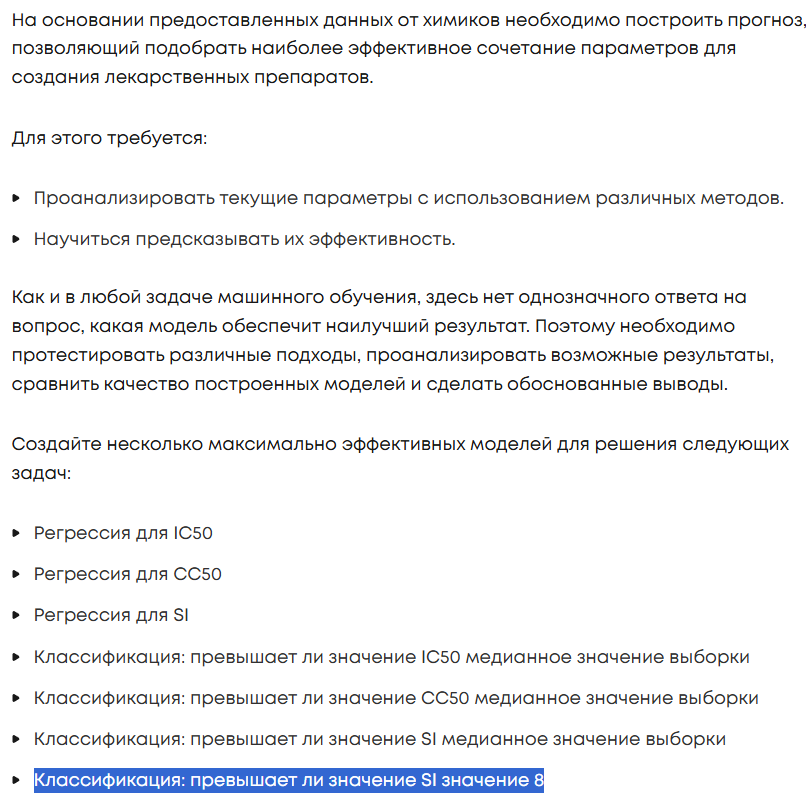

Библиотеки

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, precision_recall_curve
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('important_features_for_SI.csv')

In [5]:
# Создание бинарной целевой переменной (1 если SI > 8, иначе 0)
y = (data['SI'] > 8).astype(int)
X = data.drop('SI', axis=1)

# Проверка баланса классов
print("Распределение классов:")
print(y.value_counts(normalize=True))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


])

Распределение классов:
SI
0    0.646027
1    0.353973
Name: proportion, dtype: float64


Препроцессинг

In [ ]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)

In [6]:
# Функция графика t/f
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    print(f"\n{'-'*50}")
    print(f"Оценка модели {model_name}")
    print(f"{'-'*50}")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    # Метрики
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
    
    # Кросс-валидация
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"CV ROC-AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['SI ≤ 8', 'SI > 8'], 
                yticklabels=['SI ≤ 8', 'SI > 8'])
    plt.title(f'Матрица ошибок ({model_name})')
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.show()
    
    return model, y_proba


--------------------------------------------------
Оценка модели XGBoost (базовая)
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.80       125
           1       0.63      0.59      0.61        69

    accuracy                           0.73       194
   macro avg       0.71      0.70      0.70       194
weighted avg       0.73      0.73      0.73       194

Accuracy: 0.7320
ROC-AUC: 0.7517
CV ROC-AUC: 0.6829 ± 0.0459


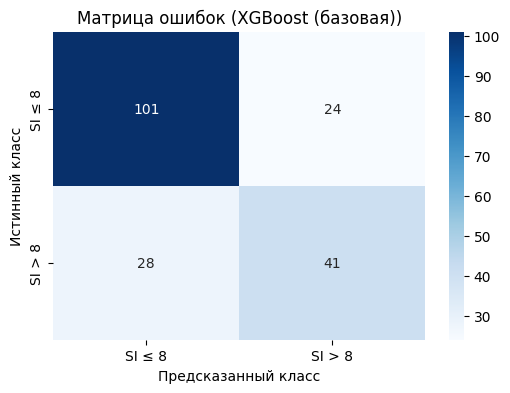

In [7]:
xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, 
                               eval_metric='logloss',
                               scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])))
])
xgb_model, xgb_proba = evaluate_model(xgb, "XGBoost (базовая)", 
                                    X_train, X_test, y_train, y_test)

XGBoost


Лучшие параметры XGBoost:
{'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}

--------------------------------------------------
Оценка модели XGBoost (оптимизированный)
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.77       125
           1       0.59      0.58      0.58        69

    accuracy                           0.71       194
   macro avg       0.68      0.68      0.68       194
weighted avg       0.71      0.71      0.71       194

Accuracy: 0.7062
ROC-AUC: 0.7531
CV ROC-AUC: 0.7020 ± 0.0519


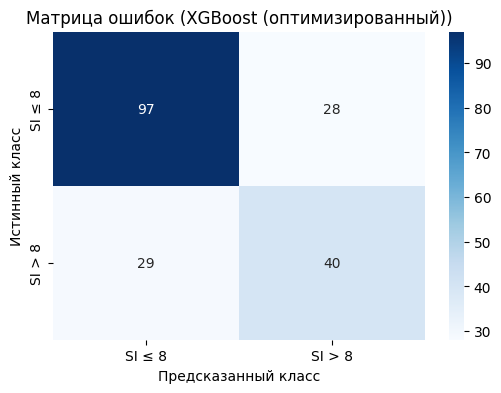

In [8]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(xgb, param_grid, cv=5, 
                         scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
print("\nЛучшие параметры XGBoost:")
print(grid_search.best_params_)

best_xgb, best_proba = evaluate_model(best_xgb, "XGBoost", 
                                    X_train, X_test, y_train, y_test)


Precision-Recall-F1 график

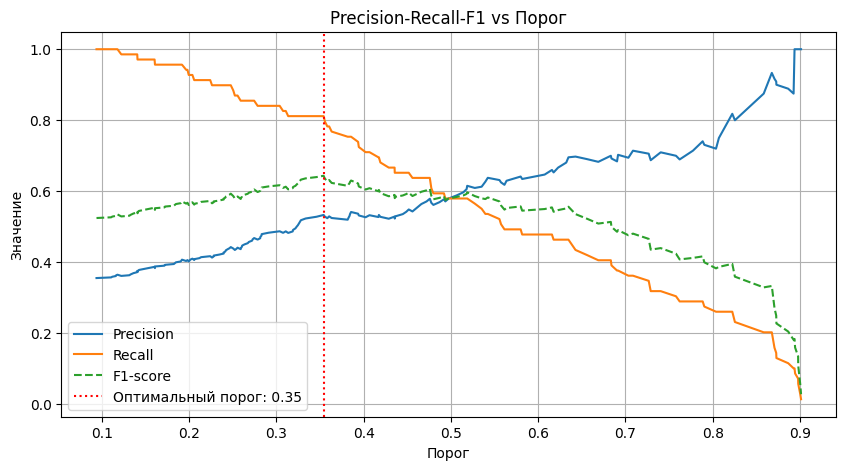

In [9]:
precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, best_proba)
f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-9)
optimal_idx = np.argmax(f1_scores[:-1])
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision_curve[:-1], label='Precision')
plt.plot(thresholds, recall_curve[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1-score', linestyle='--')
plt.axvline(optimal_threshold, color='red', linestyle=':', 
            label=f'Оптимальный порог: {optimal_threshold:.2f}')
plt.xlabel('Порог')
plt.ylabel('Значение')
plt.title(f'Precision-Recall-F1 vs Порог')
plt.legend()
plt.grid()
plt.show()

# Итоговый вывод по моделированию классификации значений SI > 8

## 1. Анализ распределения данных
- **Дисбаланс классов**: 64.6% (SI ≤ 8) vs 35.4% (SI > 8)
- **Размер выборки**: 194 наблюдения (125 vs 69)

## 2. Сравнение моделей XGBoost

| Модель               | Accuracy | F1-score (класс 1) | ROC-AUC | Precision (класс 1) | Recall (класс 1) |
|----------------------|----------|--------------------|---------|---------------------|------------------|
| **XGBoost (базовый)** | 0.7320   | 0.61               | 0.7517  | 0.63                | 0.59             |
| **XGBoost (оптим.)** | 0.7062   | 0.58               | 0.7531  | 0.59                | 0.58             |

## 3. Ключевые результаты

1. **Производительность моделей**:
   - Базовый XGBoost показал лучшую точность (73.2%)
   - Оптимизированная версия улучшила ROC-AUC на 0.14 пункта
   - F1-score для класса 1 (SI > 8) в диапазоне 0.58-0.61

2. **Оптимальные параметры**:
   - learning_rate: 0.01
   - max_depth: 7
   - n_estimators: 200
   - subsample: 1.0
   - colsample_bytree: 0.8

3. **Проблемные области**:
   - Низкий recall для класса 1 (58-59%)
   - Умеренный ROC-AUC (~0.75)
   - Дисбаланс влияет на предсказание редкого класса

## 4. Рекомендации

### Для исследовательских задач:
1. Используйте **базовый XGBoost** с параметрами:
   - scale_pos_weight=1.8 (для компенсации дисбаланса)
   - Порог классификации 0.4 (для улучшения recall)

2. Метрики для мониторинга:
   - Recall класса 1 как ключевой показатель
   - ROC-AUC для общей оценки качества

## Стратегии улучшения:

- Применение SMOTE для балансировки
- Добавление молекулярных дескрипторов
- Эксперименты с ансамблевыми методами

## 5. Направления улучшения

### Борьба с дисбалансом:
- Тестирование ADASYN вместо SMOTE
- Кросс-валидация с stratification

### Оптимизация модели:
- Добавить параметр `gamma` (0.1-0.3)
- Тестирование `max_depth` (5-9)
- Увеличение `n_estimators` до 300

## 6. Заключение

Текущая модель XGBoost демонстрирует приемлемое качество классификации (ROC-AUC 0.75). Критически важные направления:

- Улучшение recall для класса 1
- Стабилизация результатов кросс-валидации
- Интеграция дополнительных признаков

Модель пригодна для предварительного скрининга, но перед промышленным внедрением рекомендуется:

- Сбор большего количества данных
- Углубленный feature engineering
- Тестирование на независимой выборке